# Worksheet 4 - Scientific Visualization MVE080/MMG640
## 3D graphics: Blender and camera models 

Name: *Axel Eiman*

This is the fourth worksheet in the course *Scientific Visualization*. It is intended to help us understand *(a)* homogeneous coordinates, *(b)* rigid body motion, and *(c)* scaling. 

Once you're finished with all the tasks, export this document as an HTML-file and upload it in Canvas.
You are encouraged to discuss problems and solutions with your fellow students (in the class-room but also on CampusWire), but each student must solve all tasks by themselves and hand-in their own report.
Notice that Jupyter notebooks use [Markdown](https://docs.github.com/en/github/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax#links) for writing text cells. Make sure you understand the basics. You can also include $\LaTeX$ in your Markdown cells.

## Setup
Before we begin it is necessary to load a few Python modules that are needed. We can do that with the following commands (which only have to be run once, unless you restart the Jupyter kernel in which case you have to re-run them). The command `%matplotlib widget` activates interactive plotting in Jupyter. To use it you need to install `ipympl`. With `conda`, you do it as follows
```
> conda install ipympl
```

In [194]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline # change to 'widget' for interactive 

# Task 2: Triangular mesh and pinhole camera model

Also following the work in the previous worksheet, Task 4 in the worksheet requires the `TriMesh` class and in addition to that at least some of the primitive classes that were defined in Worksheet 1.

In [195]:
class TriMesh:
    """
    An object from this class represents a triangular mesh.
    It has methods for extracting vertices and triangles.
    """
    def __init__(self, vertices, triangles, color='blue'):
        self.vertices = np.asarray(vertices).astype(float)
        self.triangles = np.asarray(triangles).astype(int)
        self.color = color
    
    @property
    def x(self):
        return self.vertices[:,0]
    
    @property
    def y(self):
        return self.vertices[:,1]
    
    @property
    def z(self):
        return self.vertices[:,2]
    
    def plot(self, ax=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_box_aspect((np.ptp(self.x), np.ptp(self.y), np.ptp(self.z)))
        return ax.plot_trisurf(self.x, self.y, self.z, \
                               triangles=self.triangles, color=self.color, edgecolor='black', alpha=0.5)

    def myplot(self, camera_pos, camera_aim, focal_length=1, angle=0):
        """
        Return a 2D figure for the pinhole perspective camera projection
        of the mesh edges.
        """
        
        camera_aim = np.divide(camera_aim, np.linalg.norm(camera_aim))

        self.K = np.array([
            [focal_length, 0, 0],
            [0, focal_length, 0],
            [0, 0, 1]
        ])
        
        ax1 = np.random.randn(3)
        ax1 -= ax1.dot(camera_aim) * camera_aim
        ax1 /= np.linalg.norm(ax1)

        ax2 = np.cross(camera_aim, ax1)

        self.R = np.column_stack([ax2, ax1, camera_aim])
        # print(f'R == {self.R}')

        tmp1 = self.K @ self.R.transpose()
        tmp2 = np.concatenate([np.identity(3), -np.array([camera_pos]).transpose()], axis=1)
        self.P = tmp1 @ tmp2

        self.X = np.vstack([self.x, self.y, self.z, np.ones(shape=self.x.shape)])
        self.X /= self.X[-1,:]
        
        self.projection = self.P @ self.X 
        self.projection /= self.projection[-1,:] # Normalize 3rd coordinate to one

        fig = plt.figure()
        ax2 = fig.add_subplot(111)
        ax2.set_box_aspect(1)#np.ptp(self.projection[0,:])/np.ptp(self.projection[1,:]))

        self.triangles_complete = np.concatenate([self.triangles, np.array([self.triangles[:,0]]).transpose()], axis=1)

        for i in range(len(self.triangles)):
            ax2.plot(self.projection[0, self.triangles_complete[i]], self.projection[1, self.triangles_complete[i]], 'r')
            # TODO maybe try to unfold (or something?) the triangles thing to avoid looping
        plt.show()
        # print(f'K:\n{self.K}\nR:\n{self.R}\nP:\n{self.P}\nX:\n{self.X}\nprojection:\n{self.projection}\n')


Below is a sub-class of `TriMesh` that is suppose to implement a cube. All eight vertices of the cube are defined (in such a way that each edge has unit length and the center of the cube is at the origin). The first four triangles are defined, but the cube is not complete. Add more triangles to complete the cube. You can use the `plot()` method to view the result.

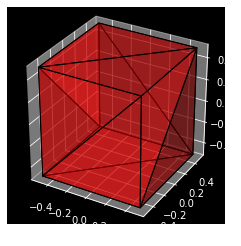

In [196]:
class Cube(TriMesh):
    
    def __init__(self, color='red'):
        
        # Vertices
        V = 0.5*np.array([[-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1], \
                          [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1]])

        # Triangles
        T = np.array([[0, 1, 2], [0, 2, 3], \
                      [0, 1, 5], [0, 5, 4], \
                      [0, 3, 4], [7, 3, 4], \
                      [2, 7, 6], [2, 3, 7], \
                      [4, 5, 6], [4, 6, 7], \
                      [1, 2, 6], [1, 5, 6]
                     ])
        
        # Call the contructor of the super class
        super().__init__(V, T, color=color)

c = Cube()
c.plot()

## Task 2.2

Your task is to implement your own 3D pinhole camera projection for visualizing the wireframe for a `TriMesh` object. Some template code is already provided in `TriMesh` above (as the method `myplot`). As arguments the `myplot` method takes:
1. the position of the camera,
2. the point the camera is aiming at,
3. and the focal length.

Notice that the complete camera orientation is not unique from the parameters above, since you can still roll the camera about its aim. To make the orientation unique, a common choice is to say that the x-axis or y-axis of the camera should be parallell with the ground plane.
For background on the pinhole camera model, see [the slides from the lecture](https://chalmers.instructure.com/courses/16191/files/1405190/download?wrap=1), and the Wikipedia page on [the pinhole camera model](https://en.wikipedia.org/wiki/Pinhole_camera_model) and [the camera matrix](https://en.wikipedia.org/wiki/Camera_matrix). 

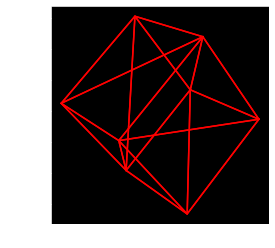

In [197]:
# Test your camera model here
camera_pos = np.array([4,3,1])
camera_aim = -camera_pos
f = 0.1
Cube().myplot(camera_pos=camera_pos, focal_length=f, camera_aim=camera_aim)


# Task 1: Introduction to Blender

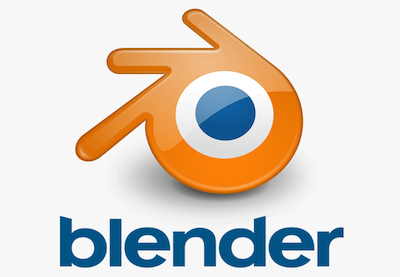

In the next part of the course we shall use the software [Blender](https://www.blender.org/). In short, Blender is the free and open source 3D creation suite. It supports the entirety of the 3D pipeline—modeling, rigging, animation, simulation, rendering, compositing and motion tracking, even video editing and game creation. Since Blender is fully Python scriptable (meaning everything you do in the graphical interface you can also do via Python), it is also popular for scientific visualization. Notice, however, that Blender is not primarily aimed for scientific visualization. For example, there are no pre-defined functions for streamplots etc. On the other hand, if you put work into it, Blender can create far more impressive renderings than you can with for example [ParaView](https://www.paraview.org/) (a tool specifically aimed at 3D scientific visualizations).

There are plenty of Blender tutorials available online. In this course, we shall use video tutorials, as it is often easier to see something being done rather than reading about it. Also, the Blender user interface is very dense, so it takes some time getting used to.

- [Blender Fundamentals](https://www.youtube.com/playlist?list=PLa1F2ddGya_-UvuAqHAksYnB0qL9yWDO6) is the official video tutorial for beginners.
- [Complete Beginner Tutorial](https://www.youtube.com/watch?v=4xLdisAvjx8&list=PLa1F2ddGya_-UvuAqHAksYnB0qL9yWDO6&index=44) is a continuation of Blender Fundamentals, which shows more the workflow in Blender.
- [Blender Guru beginners tutorial](https://www.youtube.com/playlist?list=PLjEaoINr3zgFX8ZsChQVQsuDSjEqdWMAD) is another very popular YouTube tutorial.

## Task 1.1

- [Install Blender](https://www.blender.org/download/) on your computer (it is already installed on the Linux computers). If you have a 3-button mouse, please use it. Blender is really much easier to use with a 3-button mouse.

## Task 1.2

- Watch Parts 1-11 (at least) of the [Blender Fundamentals tutorial](https://www.youtube.com/playlist?list=PLa1F2ddGya_-UvuAqHAksYnB0qL9yWDO6).
- Watch and do Parts 1-3 (at least) of the [Blender Guru beginners tutorial](https://www.youtube.com/playlist?list=PLjEaoINr3zgFX8ZsChQVQsuDSjEqdWMAD). Then answer the question below.

## Question 1.1
What is a sub-surface modifier in Blender?

## Answer 1.1
The subsurf modifier is used to give objects smoother surfaces - it splits the faces in a mesh into smaller parts to give the object a smoother appearance. 

Modifiers in blender affect the geometry of an object in a non-destructive way, meaning the base geometry of the object is unaffected. Instead they change how the object is displayed and rendered so we can work with relatively simple meshes while still getting high levels of detail. 
